In [ ]:
!pip install imgaug --upgrade
# !pip install albumentations --upgrade

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [ ]:
# Mount Drive if on Colab
on_colab = True
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  
  FOLDERNAME = 'chow chow/trainer/'
  assert FOLDERNAME is not None, "[!] Enter the foldername."

  import sys
  sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

  %cd drive/My\ Drive/$FOLDERNAME/

In [40]:
import util
import model

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np
import imgaug as ia
import sklearn

import os
from os.path import isfile 
from datetime import datetime
import time
import pickle
import pathlib

In [5]:
# Define paths to data
d = '../data/'
dirs = {
    'imgs_val':     d + 'val_data/',
    'imgs_test':    d + "test_data/",
    'lmdb_val':  d + 'val_lmdb',
    'lmdb_test': d + 'test_lmdb'
}

files = {
    'val_pkl':      d + "lmdb_val_out.pkl",
    'test_pkl':     d + "lmdb_test_out.pkl",
    'classes_pkl':  d + "classes1M.pkl",
    'rvocab_pkl':   d + "vocab.txt",
    'pt_pkl':       d + 'partition.pkl', # image ids
    'lb_pkl':       d + 'labels.pkl', # labels
    'ingr_pkl':     d + 'ingredients.pkl', # ingredient names
    # 'cl_pkl':       d + 'classes.pkl', # class names
}

In [6]:
# Read LMDB into pkl
# TODO: add train dir, out file
if not (isfile(files['val_pkl']) and isfile(files['test_pkl'])):
    print("LMDBs processing into pkls")
    
    lmdb_val_out = util.read_lmdb(dirs['lmdb_val'])
    pickle.dump(lmdb_val_out, open(files['val_pkl'], 'wb'))
    
    lmdb_test_out = util.read_lmdb(dirs['lmdb_test'])
    pickle.dump(lmdb_test_out, open(files['test_pkl'], 'wb'))
else:
    print("LMDBs already saved as pkls")


LMDBs already saved as pkls


In [7]:
# Load data
if not (isfile(files['pt_pkl']) and isfile(files['lb_pkl']) and isfile(files['ingr_pkl'])):
    print("Datasets processing for the 1st time into pkls")
    partition, labels, ingrs = util.load_data(dirs, files)
    
    pickle.dump(partition, open(files['pt_pkl'], "wb"))
    pickle.dump(labels, open(files['lb_pkl'], "wb"))
    pickle.dump(ingrs, open(files['ingr_pkl'], "wb"))
    print("Datasets loaded")
else:
    partition = pickle.load(open(files['pt_pkl'], "rb"))
    labels = pickle.load(open(files['lb_pkl'], "rb"))
    ingrs = pickle.load(open(files['ingr_pkl'], "rb"))
    print("Datasets loaded from pkls")


Datasets loaded from pkls


In [8]:
# Create data generators
data_params = {'dim': (224,224),
              'batch_size': 2,
              'n_ingrs': len(ingrs),
              'n_channels': 3,
              'shuffle': True}

image_dir_tr = dirs['imgs_val']
image_dir_val = dirs['imgs_test']

gen_tr = model.DataGenerator(partition['train'], labels, image_dir_tr, **data_params)
gen_val = model.DataGenerator(partition['validation'], labels, image_dir_val, **data_params)

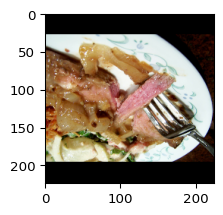

[0. 0. 0. ... 0. 0. 0.]


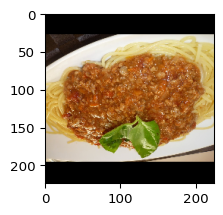

[0. 0. 0. ... 0. 0. 0.]


In [9]:
# Check generator and fetching speed
X, y = gen_tr.__getitem__(0)
for i, img in enumerate(X):
    ia.imshow(img)
    print(y[i])
    break

X, y = gen_val.__getitem__(0)
for i, img in enumerate(X):
    ia.imshow(img)
    print(y[i])
    break

In [ ]:
# Change for each experiment
trial_name = 'try_densenet'
is_init = True # choose stage of training
model_name = 'densenet'
best_init_name = '{}_{}_{}'.format('08_28', '2', 'try_densenet') # select stage 1 weights to use

# Name experiment
today = datetime.now().strftime('%m_%d')
trial_ct = len(list(pathlib.Path('logs/').rglob(today+'*/'))) + 1
exp_name =  '{}_{}_{}'.format(today, trial_ct, trial_name)
logdir = 'logs/' + exp_name
print('Running experiment ', exp_name)

# Stage 1 training
# Choose parameters for initializing the last layer
init_params = {
    'model_name': model_name,
    'lr': 1e-2,
    'input_shape': (*data_params['dim'], data_params['n_channels']),
    'num_ingrs': len(ingrs),
    'eps': 10, 
}

# Stage 2 training
# Choose parameters for transfer learning on the pre-trained model
tl_params = {
    'lr': 1e-5,
    'num_unfreeze': 4, # num layers to unfreeze from top of pre-trained model
    'init_path': '{}/{}/{}'.format('logs', best_init_name, 'best_epoch_model.h5'),
    'eps': 100,
}

# Load model
if is_init:
    print('Loaded stage 1 model')
    nn = model.create_init_model(init_params)
    eps = init_params['eps']
else:
    print('Loaded stage 2 model')
    nn = model.create_tl_model(tl_params)
    eps = tl_params['eps']

In [48]:
# Define callbacks
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

class MetricsHistory(Callback):
    def __init__(self):
        self.best_score = -1
        self.start_time = None
    
    def on_epoch_begin(self, epoch, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # Report train and val metric
        tr_score = logs['f1_ml']
        val_score = logs['val_f1_ml']
        print("\n\nTrain F1: {:2f} \nVal F1:   {:2f}".format(tr_score, val_score))
        
        # Report time taken to complete this epoch
        elapsed = (time.time() - self.start_time) / 60
        print("Epoch finshed in {:.1f} minutes".format(elapsed))

        # Save model if better
        if val_score > self.best_score:
            print("Better validation score! Saving model ...")
            if not os.path.exists(logdir):
                os.makedirs(logdir)
            self.model.save(logdir + '/best_epoch_model.h5')
            self.best_score = val_score
        print("\n\n")
        
metrics_cb = MetricsHistory()

In [ ]:
# Visualize training
%tensorboard --logdir logs/

In [49]:
# Train
history = nn.fit(gen_tr, epochs=eps, validation_data=gen_val, 
                 callbacks=[tensorboard_cb, metrics_cb])

# use_multiprocessing=True, workers=6, 
# lr_decay_cb, validation_steps=val_steps, 

Epoch 1/10
 1/10 [==>...........................] - ETA: 0s - loss: 533.9206 - f1_ml: 2.7632e-04 - prec_ml: 2.7632e-04 - recall_ml: 2.7632e-04

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - ETA: 0s - loss: 642.9612 - f1_ml: 3.5922e-04 - prec_ml: 3.7303e-04 - recall_ml: 3.5922e-04

Train F1: 0.000359 
Val F1:   0.000113
Epoch finshed in 0.1 minutes
Better validation score! Saving model ...



10/10 [==============================] - 10s 1s/step - loss: 642.9612 - f1_ml: 3.5922e-04 - prec_ml: 3.7303e-04 - recall_ml: 3.5922e-04 - val_loss: 1383.1191 - val_f1_ml: 1.1257e-04 - val_prec_ml: 1.0746e-04 - val_recall_ml: 1.2281e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 646.6033 - f1_ml: 4.2369e-04 - prec_ml: 4.4211e-04 - recall_ml: 4.1448e-04

Train F1: 0.000424 
Val F1:   0.000143
Epoch finshed in 0.1 minutes
Better validation score! Saving model ...



10/10 [==============================] - 9s 880ms/step - loss: 646.6033 - f1_ml: 4.2369e-04 - prec_ml: 4.4211e-04 - recall_ml: 4.1448e-04 - val_loss: 1422.6389 - val_f1_ml: 1.4328e-04 - val_prec_ml: 1.3816e-04 - val_recall_ml: 1.5351e-04
Epoch 3/10
10/10 [=====

In [ ]:
# Export
nn.save(logdir + "/last_epoch_model/")

In [ ]:
# Evaluate predictions
X_s, y_s = gen_val.__getitem__(1)
for i, pred in enumerate(nn.predict(X_s)):    
    truth = y_s[i]
    img = X_s[i]
    
    true_class_id = np.where(truth == 1)[0]
    pred_class_id = np.where(pred > 1e-9)[0]
    
    print("Image ", i)
    print("True: ", [ingrs[x] for x in true_class_id])
    print("Predicted: ", [ingrs[x] for x in pred_class_id])
    print()
    print(true_class_id)
    print(pred_class_id)
    print("Predicted logit: ", pred[pred_class_id])
    ia.imshow(img)